
# Comparing PLI, wPLI, and dPLI

This example demonstrates the different connectivity information captured by
the phase lag index (PLI) :footcite:`StamEtAl2007`, weighted phase lag index
(wPLI) :footcite:`VinckEtAl2011`, and directed phase lag index (dPLI)
:footcite:`StamEtAl2012` on simulated data.


In [24]:
# Authors: Kenji Marshall <kenji.marshall99@gmail.com>
#          Charlotte Maschke <charlotte.maschke@mail.mcgill.ca>
#          Stefanie Blain-Moraes <stefanie.blain-moraes@mcgill.ca>
#
# License: BSD (3-clause)


import matplotlib.pyplot as plt
import mne
import numpy as np
from mne.datasets import sample

from mne_connectivity import spectral_connectivity_epochs

## Background

The formulae for PLI, wPLI, and dPLI are given below. In these equations,
$X_{ij}$ is the cross-spectral density (CSD) between two signals
$i, j$. Importantly, the imaginary component of the CSD is maximal
when the signals have a phase difference given by $k\pi+\frac{\pi}{2}$,
and is $0$ when the phase difference is given by $k\pi$ (where
$k \in \mathbb{Z}$). This property provides protection against
recognizing volume conduction effects as connectivity, and is the backbone
for these methods :footcite:`VinckEtAl2011`. In the equations below,
$\mathcal{I}$ refers to the imaginary component,
$\mathcal{H}$ refers to the Heaviside step function, and
$sgn$ refers to the sign function.

$PLI = |E[sgn(\mathcal{I}(X_{ij}))]|$ :footcite:`StamEtAl2007`

$wPLI = \frac{|E[\mathcal{I}(X_{ij})]|}{E[|\mathcal{I}(X_{ij})|]}$
:footcite:`VinckEtAl2011`

$dPLI = E[\mathcal{H}(\mathcal{I}(X_{ij}))]$ :footcite:`StamEtAl2012`

All three of these metrics are bounded in the range $[0, 1]$.

* For PLI, $0$ means that signal $i$ leads and lags signal
  $j$ equally often, while a value greater than $0$ means that
  there is an imbalance in the likelihood for signal $i$ to be leading
  or lagging. A value of $1$ means that signal $i$ only leads or
  only lags signal $j$.
* For wPLI, $0$ means that the total weight (not the quantity) of all
  leading relationships equals the total weight of lagging relationships,
  while a value greater than $0$ means that there is an imbalance
  between these weights. A value of $1$, just as in PLI, means that
  signal $i$ only leads or only lags signal $j$.
* With dPLI, we gain the ability to distinguish whether signal $i$ is
  leading or lagging signal $j$, complementing the information provided
  by PLI or wPLI. A value of $0.5$ means that signal $i$ leads
  and lags signal $j$ equally often. A value in the range
  $(0.5, 1.0]$ means that signal $i$ leads signal $j$ more
  often than it lags, with a value of $1$ meaning that signal $i$
  always leads signal $j$. A value in the range $[0.0, 0.5)$
  means that signal $i$ lags signal $j$ more often than it leads,
  with a value of $0$ meaning that signal $i$ always lags signal
  $j$. The PLI can actually be extracted from the dPLI by the
  relationship $PLI = 2|dPLI - 0.5|$, but this relationship is not
  invertible (dPLI can not be estimated from the PLI).


Overall, these different approaches are closely related but have subtle
differences, as will be demonstrated throughout the rest of this example.



## Capturing Leading/Lagging Phase Relationships with dPLI

The main advantage of dPLI is that it's *directed*, meaning it can
differentiate between phase relationships which are leading or lagging.
To illustrate this, we generate sinusoids with Gaussian noise. In particular,
we generate signals with phase differences of
$[-\pi, -\frac{\pi}{2}, 0, \frac{\pi}{2}, \pi]$ relative to a reference
signal. A negative difference means that the reference signal is lagging the
other signal.



In [25]:
fs = 250  # sampling rate (Hz)
n_e = 30  # number of epochs
T = 2  # length of epochs (s)
f = 2  # frequency of sinusoids (Hz)
t = np.arange(0, T, 1 / fs)
A = 1  # noise amplitude
sigma = 0.5  # Gaussian noise variance

data = []

phase_differences = [0, -np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
for ps in zip(phase_differences):
    sig = []
    for _ in range(n_e):
        sig.append(
            np.sin(2 * np.pi * f * t - ps)
            + A * np.random.normal(0, sigma, size=t.shape)
        )
    data.append(sig)

data = np.swapaxes(np.array(data), 0, 1)  # make epochs the first dimension

In [26]:
data.shape

(30, 6, 500)

A snippet of this simulated data is shown below. The blue signal is the
reference signal.



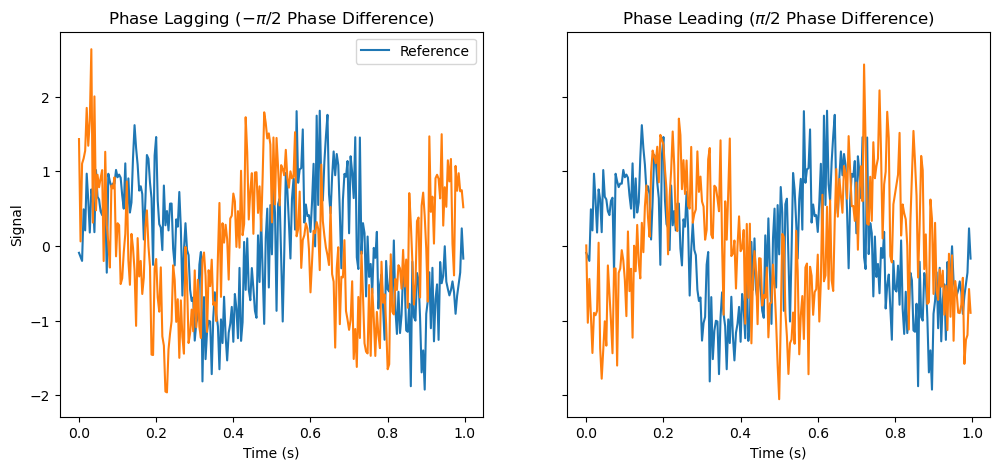

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax[0].plot(t[:fs], data[0, 0, :fs], label="Reference")
ax[0].plot(t[:fs], data[0, 2, :fs])

ax[0].set_title(r"Phase Lagging ($-\pi/2$ Phase Difference)")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Signal")
ax[0].legend()

ax[1].plot(t[:fs], data[0, 0, :fs], label="Reference")
ax[1].plot(t[:fs], data[0, 4, :fs])
ax[1].set_title(r"Phase Leading ($\pi/2$ Phase Difference)")
ax[1].set_xlabel("Time (s)")

plt.show()

We will now compute PLI, wPLI, and dPLI for each phase relationship.



In [28]:
conn = []
indices = ([0, 0, 0, 0, 0], [1, 2, 3, 4, 5])
for method in ["pli", "wpli", "dpli", "wpli2_debiased"]:
    conn.append(
        spectral_connectivity_epochs(
            data,
            method=method,
            mt_bandwidth = 2,
            mode="multitaper",
            sfreq=fs,
            indices=indices,
            fmin=f-1,
            fmax=f+1,
            # tmin=0,
            # tmax=2,
            faverage=False,
        ).get_data()#[:, 0]
    )
conn = np.array(conn)

Connectivity computation...
    computing connectivity for 5 connections
    using t=0.000s..1.996s for estimation (500 points)
    frequencies: 1.0Hz..3.0Hz (5 points)
    Using multitaper spectrum estimation with 3 DPSS windows
    the following metrics will be computed: PLI
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral de

C:\Users\Kourosh\AppData\Local\Temp\ipykernel_24216\2611149267.py:5: RuntimeWarning: fmin=1.000 Hz corresponds to 2.000 < 5 cycles based on the epoch length 2.000 sec, need at least 5.000 sec epochs or fmin=2.500. Spectrum estimate will be unreliable.
  spectral_connectivity_epochs(
C:\Users\Kourosh\AppData\Local\Temp\ipykernel_24216\2611149267.py:5: RuntimeWarning: fmin=1.000 Hz corresponds to 2.000 < 5 cycles based on the epoch length 2.000 sec, need at least 5.000 sec epochs or fmin=2.500. Spectrum estimate will be unreliable.
  spectral_connectivity_epochs(


    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    computing cross-spectral density for epoch 21
    computing cross-spectral density for epoch 22
    computing cross-spectral density for epoch 23
    computing cross-spectral density for epoch 24
    computing cross-spectral density for epoch 25
    computing cross-spectral density for epoch 26
    computing cross-spectral density for epoch 27
    computing cross-spectral density for epoch 28
    computing cross-spectral density for epoch 29
    computing cross-spectral density for epoch 30
[Connectivity computation done]
Connectivity computation...
    computing connectivity for 5 connections
    using t=0.000s..1.996s for estimation (500 points)
    frequencies: 1.0Hz..3.0Hz (5 points)
    Using multitaper spectrum estimation with 3 DPSS windows
    the following metrics will be comp

C:\Users\Kourosh\AppData\Local\Temp\ipykernel_24216\2611149267.py:5: RuntimeWarning: fmin=1.000 Hz corresponds to 2.000 < 5 cycles based on the epoch length 2.000 sec, need at least 5.000 sec epochs or fmin=2.500. Spectrum estimate will be unreliable.
  spectral_connectivity_epochs(
C:\Users\Kourosh\AppData\Local\Temp\ipykernel_24216\2611149267.py:5: RuntimeWarning: fmin=1.000 Hz corresponds to 2.000 < 5 cycles based on the epoch length 2.000 sec, need at least 5.000 sec epochs or fmin=2.500. Spectrum estimate will be unreliable.
  spectral_connectivity_epochs(


In [29]:
conn[0].shape

(5, 5)

The estimated connectivites are shown in the figure below, which provides
insight into the differences between PLI/wPLI, and dPLI.


**Similarities Of All Measures**

* Capture presence of connectivity in same situations (phase difference of
  $\pm\frac{\pi}{2}$)
* Do not predict connectivity when phase difference is a multiple of
  $\pi$
* Bounded between $0$ and $1$

**How dPLI is Different Than PLI/wPLI**

* Null connectivity is $0$ for PLI and wPLI, but $0.5$ for dPLI
* dPLI differentiates whether the reference signal is leading or lagging the
  other signal (lagging if $0 <= dPlI < 0.5$, leading if
  $0.5 < dPLI <= 1.0$)



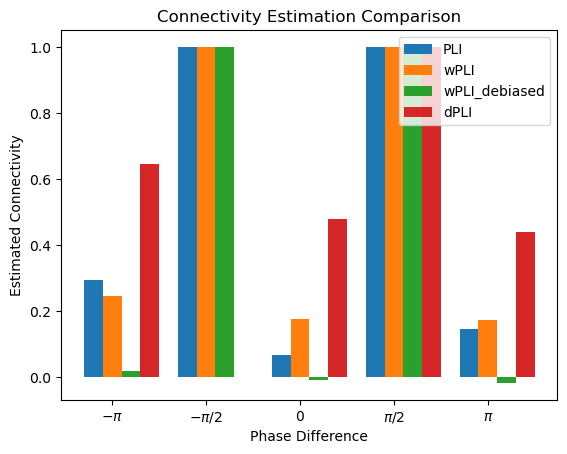

In [30]:
x = np.arange(5)

plt.figure()
plt.bar(x - 0.2, conn[0].mean(axis=1), 0.2, align="center", label="PLI")
plt.bar(x, conn[1].mean(axis=1), 0.2, align="center", label="wPLI")
plt.bar(x + 0.2, conn[3].mean(axis=1), 0.2, align="center", label="wPLI_debiased")
plt.bar(x + 0.4, conn[2].mean(axis=1), 0.2, align="center", label="dPLI")

plt.title("Connectivity Estimation Comparison")
plt.xticks(x, (r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"))
plt.legend()
plt.xlabel("Phase Difference")
plt.ylabel("Estimated Connectivity")

plt.show()

## Robustness to Outliers and Noise with wPLI

The previous experiment illustrated the advantages conferred by dPLI when
differentiating leading and lagging phase relationships. This experiment
will now focus on understanding the advantages of wPLI, and explore how it
extends upon PLI.

The main difference between PLI and wPLI is in how different phase
relationships are *weighted*. In PLI, phase differences are weighted as
$-1$ or $1$ according to their sign. In wPLI, phase differences
are weighted based on their value, meaning that phase differences closer to
$\pm\frac{\pi}{2}$ are weighted more heavily than those close to
$0$ or any other multiple of $\pi$.

This avoids a discontinuity at the transition between positive and negative
phase, treating all phase differences near this transition in a similar way.
This provides some robustness against outliers and noise when estimating
connectivity. For instance, volume conduction can distort EEG/MEG recordings,
wherein signals emanating from the same neural source will be picked up by
multiple sensors on the scalp. This can effect connectivity estimations,
bringing the relative phase differences between two signals close to
$0$. wPLI minimizes the contribution of phase relationships that are
small but non-zero (and may thus be attributed to volume conduciton), while
PLI weighs these in the same way as phase relationships of
$\pm\frac{\pi}{2}$.

To demonstrate this, we recreate a result from (Vinck et al, 2011)
:footcite:`VinckEtAl2011`. Two sinusoids are simulated, where the phase
difference for half of the epochs is $\frac{\pi}{2}$, and is
$-\frac{\pi}{100}$ for the others. We also explore the effect of
applying uniform noise to this phase difference.



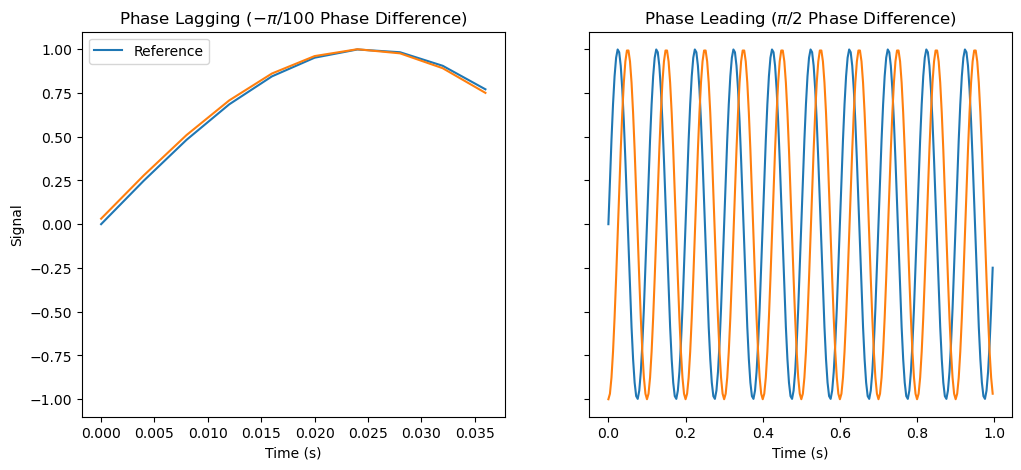

In [8]:
n_noise = 41  # amount of noise amplitude samples in [0, 4]
data = [[]]

# Generate reference
for _ in range(n_e):
    data[0].append(np.sin(2 * np.pi * f * t))

A_list = np.linspace(0, 4, n_noise)

for A in A_list:
    sig = []
    # Generate other signal
    for _ in range(int(n_e / 2)):  # phase difference -pi/100
        sig.append(
            np.sin(2 * np.pi * f * t + np.pi / 100 + A * np.random.uniform(-1, 1))
        )
    for _ in range(int(n_e / 2), n_e):  # phase difference pi/2
        sig.append(np.sin(2 * np.pi * f * t - np.pi / 2 + A * np.random.uniform(-1, 1)))
    data.append(sig)

data = np.swapaxes(np.array(data), 0, 1)

# Visualize the data
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax[0].plot(t[:10], data[0, 0, :10], label="Reference")
ax[0].plot(t[:10], data[1, 1, :10])

ax[0].set_title(r"Phase Lagging ($-\pi/100$ Phase Difference)")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Signal")
ax[0].legend()

ax[1].plot(t[:fs], data[0, 0, :fs], label="Reference")
ax[1].plot(t[:fs], data[-1, 1, :fs])
ax[1].set_title(r"Phase Leading ($\pi/2$ Phase Difference)")
ax[1].set_xlabel("Time (s)")

plt.show()

We can now compute PLI and wPLI



In [9]:
conn = []
indices = ([0] * n_noise, np.arange(1, n_noise + 1))
for method in ["pli", "wpli"]:
    conn.append(
        spectral_connectivity_epochs(
            data,
            method=method,
            sfreq=fs,
            indices=indices,
            fmin=9,
            fmax=11,
            faverage=True,
        ).get_data()[:, 0]
    )
conn = np.array(conn)

Connectivity computation...
    computing connectivity for 41 connections
    using t=0.000s..9.996s for estimation (2500 points)
    frequencies: 9.0Hz..11.0Hz (21 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-sp

The results from the simulation are shown in the figure below. In the case
without noise, the difference between wPLI and PLI is made obvious. In PLI,
no connectivity is detected, as the $-\frac{\pi}{100}$ phase
differences are weighted in the exact same way as the $\frac{\pi}{2}$
relationships. wPLI is able to avoid the cancellation of the
$\frac{\pi}{2}$ relationships.

As noise gets added, PLI increases since the $-\frac{\pi}{100}$
relationships are made positive more often than the $\frac{\pi}{2}$
relationships are made negative. However, wPLI maintains an advantage in
its ability to distinguish the underlying structure. Beyond a certain point,
the noise dominates any pre-defined structure, and both methods behave
similarly, tending toward $0$. For a more detailed analysis of this
result and the properties of wPLI, please refer to (Vinck et al, 2011)
:footcite:`VinckEtAl2011`.



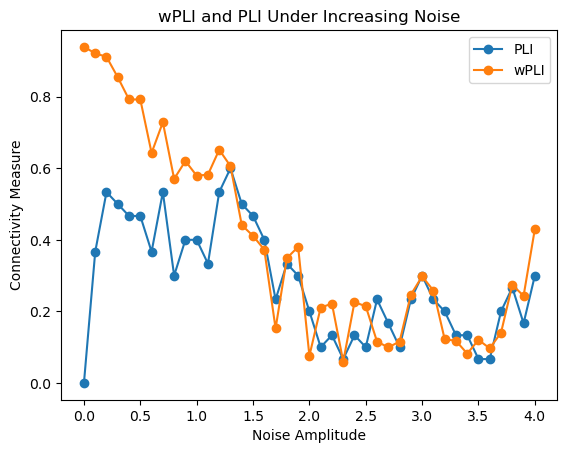

In [10]:
plt.figure()
plt.plot(A_list, conn[0], "o-", label="PLI")
plt.plot(A_list, conn[1], "o-", label="wPLI")
plt.legend()
plt.xlabel("Noise Amplitude")
plt.ylabel("Connectivity Measure")
plt.title("wPLI and PLI Under Increasing Noise")
plt.show()

## Conclusions

Both wPLI and dPLI are extensions upon the original PLI method, and provide
complementary information about underlying connectivity.

* To identify the presence of an underlying phase relationship, wPLI is the
  method of choice for most researchers as it provides an improvement in
  robustness over the original PLI method
* To know the directionality of the connectivity identified by wPLI, dPLI
  should be used

Ultimately, these methods work great together, providing a comprehensive
estimate of phase-based connectivity.



## References
.. footbibliography::

